In [1]:
import pandas

df = pandas.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [2]:
class_bias = df['classname']

In [3]:
data =[]
for clz in class_bias :
    data.append(int(clz[1]))

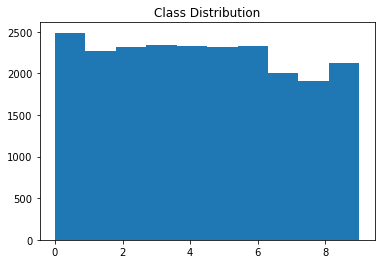

In [4]:
import matplotlib.pyplot as plt
plt.title("Class Distribution")
plt.hist(data, bins = 10)
plt.show()

In [5]:
from csv import reader
import os 

data_dir="../input/state-farm-distracted-driver-detection/imgs/train"
data_array =[ ]
# skip first line i.e. read header first and then iterate over each row od csv as a list
with open('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv', 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    # Check file as empty
    if header != None:
        # Iterate over each row after the header in the csv
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            data_file = os.path.join(data_dir , str(row[1]) , str(row[2]) )
            sample ={
                'subject': row[0] ,
                'class': row[1] ,
                'img_path': data_file
            }
            data_array.append(sample)


In [6]:
import numpy as np

import os
import random
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential ,Model

from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape
from keras.layers import merge, concatenate, Activation, Dense, Dropout, Flatten , MaxPooling2D, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from keras.utils import Sequence
from keras.utils import data_utils
from keras.utils import to_categorical
from keras import initializers

In [7]:
#define a data generator insted of loading all the images which is memory intensive
class DataGenerator(data_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_set , batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_set  = data_set
        self.on_epoch_end()
        self.image_shape=(256,256)
        self.transforms ={
            'mean':[0.485, 0.456, 0.406] ,
            'std' : [0.229, 0.224, 0.225]
        }

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_set) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch sample random indixes of batch size
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X=[]
        Y=[]
        #read images for each img file
        for idx in indexes :
            data_idx = self.data_set[idx]
            X.append(self.load_img(data_idx['img_path']))
            Y.append(int(data_idx['class'][1]))
        # Normalization => Converting pixel value from [0-255] to [0,1]  
        X = np.array(X)
        Y = np.array(Y)
        Y = to_categorical(Y, 10)
        return (X, Y)

    def on_epoch_end(self):
        'Updates indexes after each epoch ( random shuffle )'
        self.indexes = np.arange(len(self.data_set))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def load_img(self , file_name):
        
        img_rgb = load_img(file_name, grayscale=False, color_mode="rgb", 
                                              target_size=(256,256), interpolation="nearest")
        img = img_to_array(img_rgb)
        img = img /255.0
        img_normalized = ( img - self.transforms['mean'] ) / self.transforms['std']
        
        return img_normalized

In [8]:
np.random.seed(142)
train_val_split = 0.3
split_idx = int(train_val_split*len(data_array))
np.random.shuffle(data_array)

train_data = data_array[split_idx:]
val_data = data_array[:split_idx]

In [9]:
train_generator = DataGenerator(train_data)
valid_generator = DataGenerator(val_data)

In [10]:
x, y = next(iter(valid_generator))
print("Sample input batch : ", x.shape)
print("Sample target batch : ", y.shape)

Sample input batch :  (32, 256, 256, 3)
Sample target batch :  (32, 10)


In [11]:
import matplotlib.pyplot as plt
mean= [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
def viz_sample(samplex , sample_y):
    unnormalize_data = samplex*std + mean
    plt.title("Predicted Class : {}".format(str(sample_y)))
    plt.imshow(unnormalize_data)
    plt.show()

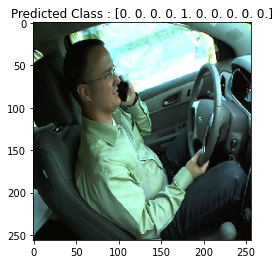

In [12]:
viz_sample(x[1] , y[1])

In [14]:
batch_size =32

In [47]:
class MyModel(Model):
    def __init__(self):
        super(MyModel , self).__init__()
        
        self.c_block1 = self.conv_block( filters=64 , kernel_size = 3 )
        self.c_block2 = self.conv_block(filters=64 , kernel_size=3 , is_maxpool=True)
        
        self.c_block3 = self.conv_block(filters=128 , kernel_size=3)
        self.c_block4 = self.conv_block(filters=128 , kernel_size=3 , is_maxpool=True)
        
        self.c_block5 = self.conv_block(filters=256 , kernel_size=3 )
        self.c_block6 = self.conv_block(filters=256 , kernel_size=3 )
        self.c_block7 = self.conv_block(filters=256 , kernel_size=3 ,dropout = 0.2 ,apply_dropout = True , is_maxpool=True)
        
        self.c_block8 = self.conv_block(filters=512 , kernel_size=3 )
        self.c_block9 = self.conv_block(filters=512 , kernel_size=3 )
        self.c_block10 = self.conv_block(filters=512 , kernel_size=3 ,dropout = 0.3 ,apply_dropout = True , is_maxpool=True)
        
        self.c_block11 = self.conv_block(filters=512 , kernel_size=3 )
        self.c_block12 = self.conv_block(filters=512 , kernel_size=3 )
        self.c_block13 = self.conv_block(filters=512 , kernel_size=3 ,dropout = 0.3 ,apply_dropout = True , is_maxpool=True)
        
        self.c_block14 = self.conv_block(filters=512 , kernel_size=8 , pad_mode='valid' , dropout=0.4 , apply_dropout=True )
        self.c_block15 = self.conv_block(filters=512 , kernel_size=1 , pad_mode='same' , dropout=0.5 , apply_dropout=True )
        
        self.out = Conv2D(filters=10 , kernel_size = 1 , strides = 1 , padding='same' , activation='softmax')
        self.reshape = Reshape((10,) , input_shape = (1,1,10))
        
        
        
    def call(self , img_data ):
        
        x =  self.c_block1(img_data)
        x =  self.c_block2(x)
        
        x =  self.c_block3(x)
        x =  self.c_block4(x)
        
        x =  self.c_block5(x)
        x =  self.c_block6(x)
        x =  self.c_block7(x)
        
        x =  self.c_block8(x)
        x =  self.c_block9(x)
        x =  self.c_block10(x)

        x =  self.c_block11(x)
        x =  self.c_block12(x)
        x =  self.c_block13(x)
        
        x = self.c_block14(x)
        x = self.c_block15(x)
        
        out = self.out(x)
     
        out = self.reshape(out)
        
        return out
        
    def conv_block(self, filters , kernel_size ,pad_mode='same', dropout=None , batch_norm = True , apply_dropout= False , is_maxpool=False):
        layers= Sequential()
        layers.add(Conv2D (filters= filters , kernel_size = kernel_size  ,
                           strides = 1 , padding = pad_mode , kernel_initializer= initializers.RandomNormal(stddev=0.02)))
        layers.add(BatchNormalization())
        layers.add(LeakyReLU(alpha=0.2))
        if(is_maxpool):
            layers.add(MaxPooling2D(pool_size=(2,2)  , strides=(2,2)  , padding='valid',data_format='channels_last'))
        if(apply_dropout):
            layers.add(Dropout(0.3))
            
        return layers
        
            
    

model = MyModel()

In [49]:
newInput = Input(batch_shape=(None,256,256,3))    # let us say this new InputLayer
newOutputs = model(newInput)
newModel = Model(newInput, newOutputs)

In [52]:
optimizer = keras.optimizers.Adam( learning_rate=0.0001, beta_1=0.9,
                                   beta_2=0.999,   epsilon=1e-07,name="Adam")
newModel.compile( optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
newModel.fit(train_generator , epochs=10 , verbose=1,
    callbacks=None,
    validation_data= valid_generator ,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator))

Epoch 1/10
490/490 [==============================] - 241s 491ms/step - loss: 0.2317 - accuracy: 0.9314 - val_loss: 0.1343 - val_accuracy: 0.9628
Epoch 2/10
490/490 [==============================] - 240s 491ms/step - loss: 0.1269 - accuracy: 0.9629 - val_loss: 0.0898 - val_accuracy: 0.9746
Epoch 3/10
490/490 [==============================] - 240s 489ms/step - loss: 0.0845 - accuracy: 0.9760 - val_loss: 0.1830 - val_accuracy: 0.9382
Epoch 4/10
490/490 [==============================] - 240s 489ms/step - loss: 0.0779 - accuracy: 0.9761 - val_loss: 0.0419 - val_accuracy: 0.9906
Epoch 5/10
490/490 [==============================] - 240s 491ms/step - loss: 0.0507 - accuracy: 0.9855 - val_loss: 0.0525 - val_accuracy: 0.9845
Epoch 6/10
490/490 [==============================] - 239s 488ms/step - loss: 0.0387 - accuracy: 0.9885 - val_loss: 0.0454 - val_accuracy: 0.9866
Epoch 7/10
490/490 [==============================] - 239s 489ms/step - loss: 0.0429 - accuracy: 0.9865 - val_loss: 0.0458 -

# TFlite model conversion methods

In [63]:
import tensorflow as tf 
import pathlib

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save the model
tflite_file = pathlib.Path("my_model.tflite")
tflite_file.write_bytes(tflite_model)

127058584

In [64]:
#tf lite model interpretation

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [65]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [66]:
input_details

[{'name': 'input_5',
  'index': 0,
  'shape': array([  1, 256, 256,   3], dtype=int32),
  'shape_signature': array([ -1, 256, 256,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [67]:
input_data = np.array([x[0]]).astype(np.float32)
input_data.shape

(1, 256, 256, 3)

In [68]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tf_results = interpreter.get_tensor(output_details[0]['index'])

In [69]:
tf_results

array([[2.0412530e-03, 1.4806354e-05, 3.6572688e-05, 2.1593676e-05,
        9.9642307e-01, 1.7748817e-04, 1.1528814e-03, 2.5775178e-05,
        1.0170093e-04, 4.8565644e-06]], dtype=float32)

In [71]:
def load_test(file_name):
        
    img_rgb = load_img(file_name, grayscale=False, color_mode="rgb", 
                                              target_size=(256,256), interpolation="nearest")
    img = img_to_array(img_rgb)
    img = img /255.0
    img_normalized = ( img - mean ) / std
    
    return img_normalized

In [72]:
def class_map(prediction):
    if(prediction==0):
        return 'safe driving'
    if(prediction==1):
        return 'texting - right'
    if(prediction==2):
        return 'talking on the phone - right'
    if(prediction==3):
        return 'texting - left'
    if(prediction==4):
        return 'talking on the phone - left'
    if(prediction==5):
        return 'operating the radio'
    if(prediction==6):
        return 'drinking'
    if(prediction==7):
        return 'reaching behind'
    if(prediction==8):
        return 'hair and makeup'
    if(prediction==9):
        return 'talking to passenger'
        

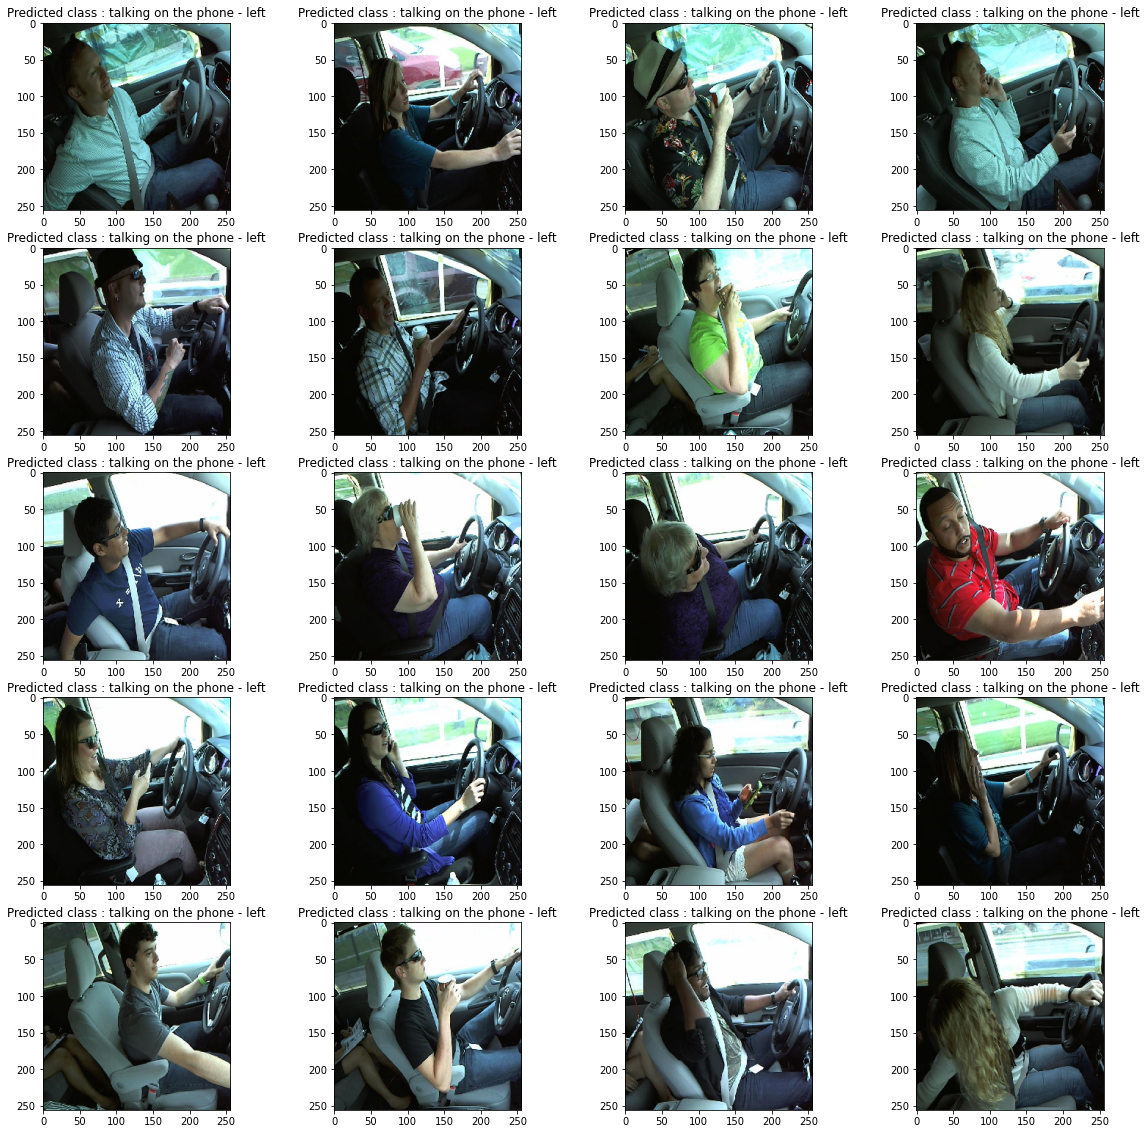

In [77]:
import numpy as np
#load the test images for evaluation
data_dir = '../input/state-farm-distracted-driver-detection/imgs/test'
test_img_list = os.listdir('../input/state-farm-distracted-driver-detection/imgs/test')
#get some random samples from the dataset
plt.figure(figsize=(20,20)) # specifying the overall grid size
for i_check in range(20):
    #random choice of img path
    img_path = os.path.join(data_dir , np.random.choice(test_img_list))
    #load the image
    img_norm = load_test(img_path)
    single_batch = np.array([img_norm]).astype(np.float32)
    mtf_results = model.predict(single_batch)
    max_class = np.argmax(tf_results)
    class_name = class_map(max_class)
    img_rgb = img_norm*std + mean
    plt.subplot(5,4,i_check+1)    # the number of images in the grid is 5*5 (25)
    plt.title("Predicted class : {}".format(str(class_name)))
    plt.imshow(img_rgb)
plt.show()    